This is just a fun little notebook put together to mess with the star classification set posted here: https://www.kaggle.com/brsdincer/star-type-classification

I'd like to find more datasets like this in the near future to work with, as this one isn't a particularly difficult one. I'm using XGBoost, though some pretty good solutions with KNN were implemented on that page yielding great results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA # Test out some dimensionality reducing techniques on the stars dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from xgboost import XGBClassifier

Here we'll start poking through the stars dataset

In [2]:
stars_dataset = pd.read_csv('Datasets/Stars.csv')
print(stars_dataset.head())

# Fix up some colors with ambiguous names
stars_dataset=stars_dataset.replace('Blue White','Blue-White')
stars_dataset=stars_dataset.replace('Blue white','Blue-White')
stars_dataset=stars_dataset.replace('Blue-white','Blue-White')
stars_dataset=stars_dataset.replace('Yellowish White','White-Yellow')
stars_dataset=stars_dataset.replace('yellow-white','White-Yellow')
stars_dataset=stars_dataset.replace('Whitish','White')
stars_dataset=stars_dataset.replace('white','White')
stars_dataset=stars_dataset.replace('yellowish','Yellow')
stars_dataset=stars_dataset.replace('Yellowish','Yellow')

stars_X = stars_dataset[["Temperature","L","R","A_M","Color","Spectral_Class"]] # Input features

# Convert our non-numerical columns to integers
star_color_ints=pd.factorize(stars_X.Color)[0]
stars_X=stars_X.drop('Color',axis=1)
stars_X['Color']=star_color_ints

spectral_class_ints=pd.factorize(stars_X.Spectral_Class)[0]
stars_X=stars_X.drop('Spectral_Class',axis=1)
stars_X['Spectral_Class']=spectral_class_ints

# Display the corrected input data
print(stars_X.head())

stars_Y = stars_dataset[["Type"]] # Output Labels



   Temperature         L       R    A_M Color Spectral_Class  Type
0         3068  0.002400  0.1700  16.12   Red              M     0
1         3042  0.000500  0.1542  16.60   Red              M     0
2         2600  0.000300  0.1020  18.70   Red              M     0
3         2800  0.000200  0.1600  16.65   Red              M     0
4         1939  0.000138  0.1030  20.06   Red              M     0
   Temperature         L       R    A_M  Color  Spectral_Class
0         3068  0.002400  0.1700  16.12      0               0
1         3042  0.000500  0.1542  16.60      0               0
2         2600  0.000300  0.1020  18.70      0               0
3         2800  0.000200  0.1600  16.65      0               0
4         1939  0.000138  0.1030  20.06      0               0


In [3]:
n_components = 6

pca = PCA(n_components=n_components)
stars_X_PCA = pca.fit_transform(stars_X)

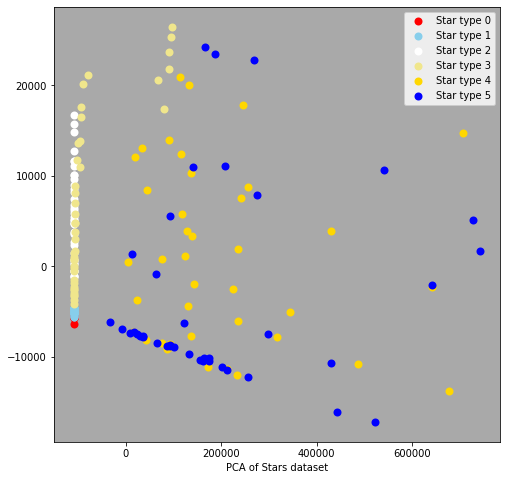

In [4]:
# Star color matchup: ['Red', 'Blue-White', 'White', 'White-Yellow', 'Pale yellow orange', 'Blue', 'Orange', 'Yellow', 'Orange-Red']
colors = ["red","skyblue","white","khaki","gold","blue","orange","yellow","orangered"] # Use this for pyplot colors, feels appropriate

plt.figure(figsize=(8,8))
ax = plt.axes() 
ax.set_facecolor("darkgrey") # Makes for a nicer figure in night mode

for color, i, star_type in zip(colors,list(range(0,int(stars_Y.nunique()))),list(stars_Y.Type.unique())):
    plt.scatter(
        stars_X_PCA[np.array(stars_Y==i).flatten(),0],
        stars_X_PCA[np.array(stars_Y==i).flatten(),1],
        color=str(color),
        lw=2,
        label="Star type " + str(star_type)
    )


plt.xlabel("PCA of Stars dataset")
plt.legend(loc="best", scatterpoints=1)
plt.show()

We can see some nice, distinguished clusters which is good (I just wanted to play with PCA on a novel dataset). Now lets play around with some gradient boosting.

In [7]:
# A ridiculously high test split, yes, but it is too easy of a problem when we have more reasonable testing parameters (~100% accuracy)! 
X_train,X_test,y_train,y_test = train_test_split(np.array(stars_X),np.array(stars_Y).flatten(),test_size=0.85,random_state=42)

star_model = XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',use_label_encoder=False)
star_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [8]:
y_pred=star_model.predict(X_test)
print("Accuracy: " + str(np.sum(y_pred==y_test)/len(y_pred)))

Accuracy: 0.9705882352941176
